# Bank Marketing AutoAI Model Test

### Watson Machine Learning認証情報の設定

In [1]:
wml_credentials = {
  "instance_id": "xxxx",
  "password": "xxxx",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "xxxx"
}    

### APIのScoring URL設定

In [2]:
# scoring URLの設定
scoring_url = "xxxx"

### 必要ライブラリのimport

In [3]:
import urllib3, requests, json
import urllib.request

In [4]:
import numpy as np
import pandas as pd
from IPython.display import display

### Watson ML呼出し準備

In [5]:
# Basic認証用ヘッダの生成
auth = '{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password'])
header_basic_auth = urllib3.util.make_headers(basic_auth=auth)
url = '{}/v3/identity/token'.format(wml_credentials['url'])

# Tokenの取得
mltoken =  json.loads( requests.get(url, headers=header_basic_auth).text )['token']
#print(mltoken)

In [6]:
# Header の組立て
header_token = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}
ml_instance_id = wml_credentials["instance_id"]
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken, 'ML-Instance-ID': ml_instance_id}

In [ ]:
### テスト用CSV読み込み
# 学習に利用していない 521件のデータをまとめて読み込みます。

In [9]:
# ファイルをカレントディレクトリにダウンロード
csv_url = 'https://raw.githubusercontent.com/makaishi2/sample-data/master/data/bank-4000-rest.csv'
csv_filename = 'bank-4000-rest.csv'
urllib.request.urlretrieve(csv_url, csv_filename)

('bank-4000-rest.csv', <http.client.HTTPMessage at 0x7f1f7a59c9e8>)

In [13]:
# データフレームに読み込み
df_bank_test = pd.read_csv('bank-4000-rest.csv', names=["age","job","marital","education","default","balance",
    "housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome","Y"])

In [14]:
display(df_bank_test.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Y
0,53,admin.,divorced,secondary,no,26,yes,no,cellular,7,may,56,1,359,1,failure,no
1,36,technician,married,secondary,no,191,no,no,cellular,31,aug,69,1,-1,0,unknown,no
2,58,technician,divorced,secondary,no,-123,no,no,cellular,5,aug,131,2,-1,0,unknown,no
3,26,student,single,secondary,no,-147,no,no,unknown,4,jun,95,2,-1,0,unknown,no
4,34,technician,single,secondary,no,179,no,no,cellular,19,aug,294,3,-1,0,unknown,no


### 正解データ correctの抽出

In [16]:
correct = df_bank_test['Y'].values
print(correct[:50])

['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'no' 'no' 'no'
 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no']


### API呼出し用入力データ配列の作成

In [17]:
df_sub = df_bank_test.copy()

# 目的変数列の削除
df_sub = df_sub.drop('Y', axis=1)

# np.nan値をNoneに置き換え
df_sub = df_sub.where((pd.notnull(df_sub)), None)

In [19]:
display(df_sub.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,53,admin.,divorced,secondary,no,26,yes,no,cellular,7,may,56,1,359,1,failure
1,36,technician,married,secondary,no,191,no,no,cellular,31,aug,69,1,-1,0,unknown
2,58,technician,divorced,secondary,no,-123,no,no,cellular,5,aug,131,2,-1,0,unknown
3,26,student,single,secondary,no,-147,no,no,unknown,4,jun,95,2,-1,0,unknown
4,34,technician,single,secondary,no,179,no,no,cellular,19,aug,294,3,-1,0,unknown


In [20]:
# DataFrameから項目名Listの生成
fields = df_sub.columns.tolist()
print(fields)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [21]:
# DataFrameから入力用Listの生成
values = df_sub.values.tolist()
# テスト用
#values = df_sub.head(2).values.tolist()
print(values[:2])

[[53, 'admin.', 'divorced', 'secondary', 'no', 26, 'yes', 'no', 'cellular', 7, 'may', 56, 1, 359, 1, 'failure'], [36, 'technician', 'married', 'secondary', 'no', 191, 'no', 'no', 'cellular', 31, 'aug', 69, 1, -1, 0, 'unknown']]


In [22]:
# payload変数の組立て
payload_scoring = {"input_data": [{
    "fields": fields, 
    "values": values
}]}

### APIの呼出し

In [23]:
# APIの呼出し
response_scoring = requests.post(scoring_url,  json=payload_scoring, headers=header)

### 戻り値のparese

In [24]:
# 戻り値のparse
res = json.loads(response_scoring.text)

pred = res['predictions'][0]
pred_values = pred['values']
pred_fields = pred['fields']
df_res = pd.DataFrame(pred_values, columns = pred_fields)

In [25]:
display(df_res.head())

,prediction,probability
0,no,"[0.9413460860089278, 0.05865391399107223]"
1,no,"[0.9839439849098387, 0.016056015090161264]"
2,no,"[0.9689762848893887, 0.0310237151106113]"
3,no,"[0.983296011477629, 0.016703988522371004]"
4,no,"[0.9097652531664269, 0.09023474683357308]"


### 精度評価

In [26]:
# 予測値の抽出
prediction = df_res['prediction'].values

# 確率値のリスト取得
w1 = df_res['probability'].values.tolist()
probas = [item[1] for item in w1]

In [27]:
# Accuracyの計算
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(correct, prediction)

In [29]:
# ROC AUCの計算
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# fpr, tpr値の取得
fpr, tpr, thresholds = roc_curve(correct, probas, pos_label='yes')

# ROC AUCの計算
roc_auc = auc(fpr, tpr)

In [34]:
# 混同行列の計算
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(correct, prediction)
df_matrix = pd.DataFrame(matrix, columns=['no', 'yes'], index=['no', 'yes'])

### 精度評価結果表示

In [42]:
### 混同行列表示
display(df_matrix)

,no,yes
no,447,11
yes,41,22


In [ ]:
#### 上記の意味

元々は10件に1件しか成約がなかったのが、  
モデルで予測することにより63件中22件成約できることになります。

In [41]:
# AccuracyとROC AUCの表示

print("Accuracy: %0.3f" % accuracy)
print("ROC AUC : %0.3f" % roc_auc)

Accuracy: 0.900
ROC AUC : 0.887


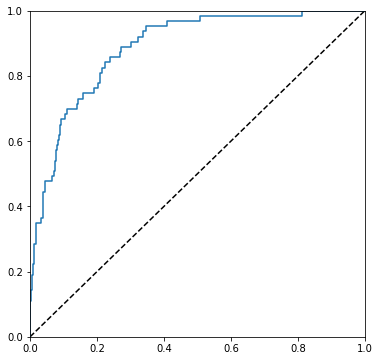

In [43]:
# ROC曲線の描画

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()